# Исследование результатов А/В теста 

В нашем распоряжении данные, предоставленные маркетинговым и аналитическим отделом компании `N`, которые содержат информацию о пользователях, совершаемых ими действиях (событиях), а также о проводимых маркетинговых акциях и А/В тестах. Так же нам было предоставлено техническое задание

**ЦЕЛЬ ИССЛЕДОВАНИЯ** провести анализ результатов А/В-теста `recommender_system_test`.

**Задачи исследования** 
* Подготовить данные и оценить корректность проведения теста, в том числе соответствие данных предоставленному ТЗ
* Проанализировать результаты теста

**Практическая значимость** исследования заключается в использовании полученных результатов для возможной корректировки организации, проведения и сбора информации по А/В тесту, или в случае корректности теста, выстраивание маркетинговых стратегий с оглядкой на его результаты.

## Обзор данных

In [1]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
from plotly import graph_objects as go
import datetime
import numpy as np
from plotly.subplots import make_subplots
from itertools import chain
import seaborn as sns
#import plotly.graph_objs as go
from plotly import tools
import plotly.io
import scipy.stats as stats
import scipy
import math
from statistics import mean
from datetime import datetime
import plotly.io as pio

In [2]:
pio.renderers.default = 'png'

In [3]:
try:
    events = pd.read_csv('final_ab_events.csv')
    marketing = pd.read_csv('ab_project_marketing_events.csv')
    users = pd.read_csv('final_ab_new_users.csv')
    partpants = pd.read_csv('final_ab_participants.csv')
    
except:
    events = pd.read_csv('/datasets/final_ab_events.csv')
    marketing = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    users = pd.read_csv('/datasets/final_ab_new_users.csv')
    partpants = pd.read_csv('/datasets/final_ab_participants.csv')
   

In [4]:
display(events.sample(3))
events.info()

,user_id,event_dt,event_name,details
261019,6423ACAE53F2496D,2020-12-08 20:18:53,login,NaN
396925,3360F353E991E3E6,2020-12-23 11:54:26,login,NaN
88442,9B9827D7D8CF22BD,2020-12-17 07:37:27,product_cart,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


Нужно: 
* `event_dt` перевести в дату
* Разобраться с причинами пропусков в `details`

Согласно документации к файлу:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

Заметим, что в документации есть неточность. В столбце `event_dt` хранится дата события, а не дата покупки. В баг-репорт.

In [5]:
display(marketing.head(3))
marketing.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Пропусков нет. `start_dt` и `finish_dt` нужно привести к дате.

Согласно документации к данным:
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [6]:
display(users.head(3))
users.info()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


`first_date` к дате. Пропусков нет.

Согласно документации к данным:
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [7]:
display(partpants.head(3))
partpants.info()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Согласно документации к данным:
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

**ВЫВОДЫ**<br>
* В таблице `evants` обнаружили пропуски в столбце `details`. 
* Обнаружили тип `object` для полей с датами в `evants` (поле `event_dt`), в `marketing` (поля `start_dt` и `finish_dt`), в `users` (поле `first_date`).
* Заметили неточность описания полей в документации. В столбце `event_dt` таблицы `events` хранится дата события, а не дата покупки.

## Предобработка данных

На этапе обзора данных были обнаружены поля с датами с типом данных `object` и пропуски в отдельных полях. Исправим, исследуем.

### Преобразование типов данных

In [8]:
events.event_dt = pd.to_datetime(events.event_dt)
marketing.start_dt = pd.to_datetime(marketing.start_dt, format='%Y-%m-%d')
marketing.finish_dt = pd.to_datetime(marketing.finish_dt, format='%Y-%m-%d')
users.first_date = pd.to_datetime(users.first_date, format='%Y-%m-%d')

Заметим, что в столбце `event_dt` таблицы `events` помимо даты присутствует время события. Пока не стали отсекать время, при необходимости всегда можем создать дополнительный столбец только с датой.

### Пропуски

На этапе обзора данных были обнаружены пропусков таблице `events` в столбце `details`, который из документации к данным должен содержать дополнительные данные о событии, например цену покупки. Рассмотрим подробнее.

In [9]:
# Процент пропусков в events
round(events.isna().sum()/events.shape[0], 2).sort_values(ascending=False)

details       0.86
user_id       0.00
event_dt      0.00
event_name    0.00
dtype: float64

86% пропусков в details

In [10]:
display(events['details'].count())

events['event_name'].value_counts()

62740

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Заметим, что количество значений в `details` совпало с количеством значений в `purchase`. Возможно там данные только о покупках.

In [11]:
print('Количество строк events без покупок:', events.query('event_name != "purchase"').shape[0])
print('Количество строк с пропусками в details без purchase:', 
      events[(events['event_name'] != 'purchase')& (events.details.isna() == True)].shape[0])

Количество строк events без покупок: 377577
Количество строк с пропусками в details без purchase: 377577


Совпало. Значит в `details` информация исключительно о покупках, т.е. стоимость покупки в долларах, причем есть стоимость каждой покупки (проверили ранее). Значит снова неточность в документации к данным. В баг-репорт.

Переименуем этот столбец в `price`


In [12]:
# Дадим столбцу имя лучше отражающие содержащиеся в нем данные
events = events.rename(columns={'details':'price'})
# Здесь же добавим столбец date, в котором будет храниться дата события без времени
events['date'] = events['event_dt'].dt.date

Готово. С пропусками разобрались. Критичных нет, просто нет доп. информации о событиях кроме цены покупки, поэтому переименовали `details` таблицы `events` в `price`. Столбец `date` с датой (только датой) события создали. 

### Дубликаты

Дабы не получить искаженные результаты исследования избавимся от явных и неявных дубликатов.

In [13]:
df_list = [events, marketing, users, partpants]
name_df = ['events', 'marketing', 'users', 'partpants']
for value, name in zip(df_list, name_df):
    print('Количество дубликатов в', name, '-', value.duplicated().sum())

Количество дубликатов в events - 0
Количество дубликатов в marketing - 0
Количество дубликатов в users - 0
Количество дубликатов в partpants - 0


Явных дубликатов нет. Чтобы проверить на неявные дубликаты, проверим регистры и выведем списки уникальных значений соответствующих столбцов.

Начнем с `events`

In [14]:
# Нет ли дубликатов связанных с различным регистром в user_id
events.user_id = events.user_id.apply(lambda x: x.lower())
if events.duplicated().sum() != 0:
    print('Такие дубликаты есть')
else: print('Таких дубликатов нет')

Таких дубликатов нет


Далее `marketing`

In [15]:
print(marketing.name.value_counts())
print()
print(marketing.regions.value_counts())

# Приведем к нижнему регистру значения
marketing.name = marketing.name.apply(lambda x: x.lower())
marketing.regions = marketing.regions.apply(lambda x: x.lower())

print(marketing.name.value_counts())
print()
print(marketing.regions.value_counts())

Christmas&New Year Promo            1
St. Valentine's Day Giveaway        1
St. Patric's Day Promo              1
Easter Promo                        1
4th of July Promo                   1
Black Friday Ads Campaign           1
Chinese New Year Promo              1
Labor day (May 1st) Ads Campaign    1
International Women's Day Promo     1
Victory Day CIS (May 9th) Event     1
CIS New Year Gift Lottery           1
Dragon Boat Festival Giveaway       1
Single's Day Gift Promo             1
Chinese Moon Festival               1
Name: name, dtype: int64

APAC                        4
EU, CIS, APAC, N.America    3
EU, N.America               2
EU, CIS, APAC               2
CIS                         2
N.America                   1
Name: regions, dtype: int64
christmas&new year promo            1
st. valentine's day giveaway        1
st. patric's day promo              1
easter promo                        1
4th of july promo                   1
black friday ads campaign           1
chines

Здесь тоже все в порядке. Теперь `users` проверим снова дубликаты после лоурезации `user_id` и выведем количества уникальных в  `device`

In [16]:
users.user_id = users.user_id.apply(lambda x: x.lower())
print('Количество дубликатов в user_id после лоурезации:', users.duplicated().sum())
print()
print('Уникальные записи поля device:\n', users.device.value_counts())
print()
partpants.user_id = partpants.user_id.apply(lambda x: x.lower())
print('Количество дубликатов после лоурезации user_id:', partpants.duplicated().sum())

Количество дубликатов в user_id после лоурезации: 0

Уникальные записи поля device:
 Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

Количество дубликатов после лоурезации user_id: 0


Тоже все в порядке. В итоге ни явных ни неявных дубликатов не обнаружили. 

Заметим, что пользователей заходивших на ресурс с `Android` наибольшее количество, на втором месте `PC`, на третьем `iPhone` на четвертом `Mac`. Не будем откладывать и посмотрим на распределение устройств, с которых пользователи заходят на ресурс.

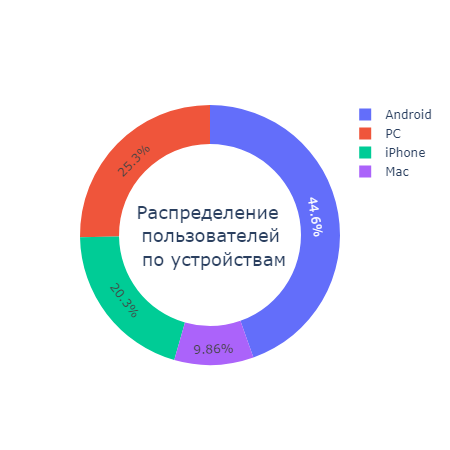

In [17]:
device = users.device.value_counts().reset_index().rename(columns={'index':'device', 'device':'count'})

fig = go.Figure()
fig.add_trace(go.Pie(values=device['count'], labels=device.device, hole=0.7))

fig.update_layout(
    autosize=False,
    width = 450,
    height = 450,
    annotations=[dict(text='Распределение <br> пользователей <br> по устройствам',
                      x=0.5, y=0.5, font_size=18, showarrow=False)])

fig.show()

Чуть меньше половины заходят с `Android`, 1/4 и 1/5 с `PC` и `iPhone` соответственно и примерно 1/10 с `Mac`

### Аномальные значения

In [18]:
# Воспользуемся ранее созданной функцие для работы с аномальными значениями
def animals(df_t, column, y_title):
    # Визуализация набора значений, диаграмма размаха
    fig = px.box(df_t, x=column)
    fig.update_layout(
                  autosize=False,
                  width=900,
                  height=400,
                  title= 'Диаграмма размаха'+' '+column,
                  xaxis_title=y_title,
                  yaxis_title=column,
                  margin=dict(l=0, r=0, t=60, b=0))
    
    fig.show()
    # Дополнительная информация, стат. характеристики набора значений столбца
    return df_t[column].describe()

Значения `price` в `events`

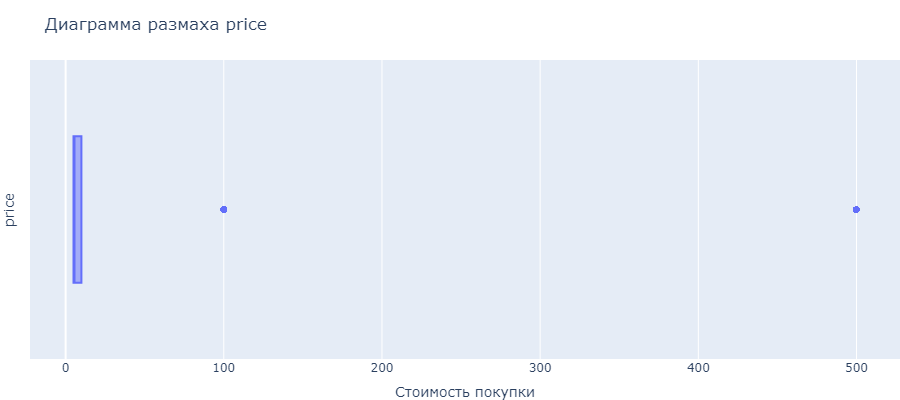

count    62740.000000
mean        23.877631
std         72.180465
min          4.990000
25%          4.990000
50%          4.990000
75%          9.990000
max        499.990000
Name: price, dtype: float64

In [19]:
animals(events, 'price', 'Стоимость покупки')

Большая часть значений 4.99, отдельные выбросы 99.99 и 499.99. Рассмотрим подробнее сколько каких значений.

,price,count
0,4.99,46362
1,9.99,9530
2,99.99,5631
3,499.99,1217


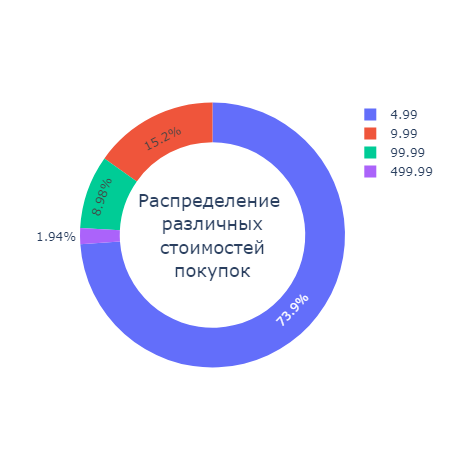

In [20]:
df_price = events.price.value_counts().reset_index().rename(columns={'index':'price', 'price':'count'})
display(df_price)

fig = go.Figure()
fig.add_trace(go.Pie(values=df_price['count'], labels=df_price.price, hole=0.7))

fig.update_layout(
    autosize=False,
    width = 450,
    height = 450,
    annotations=[dict(text='Распределение <br> различных <br> стоимостей <br> покупок <br>',
                      x=0.5, y=0.5, font_size=18, showarrow=False)])

fig.show()

Почти 3/4 значений  - 4.99, 15% - 9.99, около 9% - 99.99 и лишь 2% - 499.99. Все возможные значения стоимостей покупок с разницей между соседними в 2, в 10 и в 5 раз. Возможно, если бы мы исследовали изменение среднего чека покупки, то выбросы надо было бы ликвидировать (так как имеем сильное отрицательное смещение распределения), но в нашем случае они не влияют на конверсию, а терять пользователей теста не хотелось бы.

**ВЫВОДЫ**<br>
* Преобразовали типы данных столбцов, которые содержали даты.
* Добавили столбец `date` в `events`, только с датой события.
* Исследовали пропуски столбца `details`. Переименовали его в `price` так как он содержит только цену покупки.
* Исследовали на дубликаты. Дубликатов нет.
* Исследовали на аномальные значения `price`. Обнаружили отдельные большие значения (499.99 - 2% от числа всех).
* Заметили, что медиана в почти в 5 раз меньше среднего, т.е. большая часть покупок 4.99 и 9.99, менее 1/10 - 99.99.
* Рассмотрели распределение пользователей по устройствам. Почти половину всех устройств составляют `Android`, далее почти равные доли `PC` и `iPhone` и около 1/10 - `Mac`.

## Оценика корректности проведения теста

Посмотрим на **техническое задание:**

- Название теста: `recommender_system_test` далее `RST`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
Проверим полученные данные на соответствие их техническому заданию.
    
Помимо прочего проверим были ли задействованы пользователи исследуемого теста в других тестах. Как они распределились между группами нашего теста.

### Соответствие данных требованиям ТЗ

Начнем с **выбора интересующиего нас теста `recommender_system_test`**

In [21]:
# Посмотрим какие еще есть тесты
partpants.ab_test.value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Самый многочисленный `interface_eu_test`, интересующий нас проигрывает ему по количеству пользователей почти в два раза, у нас их всего 6701. 

Отфильтруем и посмотрим какое разбиение групп А и В.

In [22]:
part_rst = partpants.query('ab_test == "recommender_system_test"')
part_iet = partpants.query('ab_test != "recommender_system_test"')
print('Группы А и В RST теста:\n', part_rst.group.value_counts())
print('Группы А и В IET теста:\n', part_iet.group.value_counts())
print()
print('Всего пользователей:', partpants.user_id.nunique())

Группы А и В RST теста:
 A    3824
B    2877
Name: group, dtype: int64
Группы А и В IET теста:
 A    5831
B    5736
Name: group, dtype: int64

Всего пользователей: 16666


Пользователей по группам А и В RST распределены как 4/3. 

Какое-то количество пользователей попало в оба теста. Посмотрим какое.

In [23]:
res_list = list(set(part_rst['user_id'].to_list()) & set(part_iet['user_id'].to_list()))

print('Количество пользователей попавших в оба теста:', len(res_list))

Количество пользователей попавших в оба теста: 1602


Теперь есть список пользователей попавших в оба теста `res_list`. Посмотрим как эти пользователи распределились между группами `RST` теста. 

In [24]:
a_list = part_rst[(part_rst['group'] == 'A') & (part_rst['user_id'].isin(res_list))].user_id.to_list()
b_list = part_rst[(part_rst['group'] == 'B') & (part_rst['user_id'].isin(res_list))].user_id.to_list()


print('Количество таких пользователей в группе А - ', len(a_list))
print('Количество таких пользователей в группе В - ', len(b_list))

Количество таких пользователей в группе А -  921
Количество таких пользователей в группе В -  681


Отношение количества таких пользователей в группах А и В практически равно отношению количества пользователей в самих группах А и В.

Посмотрим теперь аналогичное вхождение, но только группы В из IET в группы RST.

In [25]:
list_iet_users_b = part_iet.query('group == "B"')['user_id'].to_list()

a_list = part_rst[(part_rst['group'] == 'A') & (part_rst['user_id'].isin(list_iet_users_b))].user_id.to_list()
b_list = part_rst[(part_rst['group'] == 'B') & (part_rst['user_id'].isin(list_iet_users_b))].user_id.to_list()


print('Количество таких пользователей в группе А - ', len(a_list))
print('Количество таких пользователей в группе В - ', len(b_list))

Количество таких пользователей в группе А -  439
Количество таких пользователей в группе В -  344


Предполагая, что во втором тесте группа В - тестовая, а значит на ее пользователей раскатывали какое-то обновление (возможно интерфейса) и тем самым оказывали влияние, то целесообразно исключить таких пользователей из нашего теста. (Подробную информацию можно узнать только у организаторов теста и сбора данных, в баг-репорте зададим этот вопрос)

In [26]:
rst_users_list = list((set(part_rst.user_id.to_list()) - set(a_list)) - set(b_list))
print('Наш список c', len(rst_users_list), 'пользователями')

Наш список c 5918 пользователями


Отметим, что количество пользователей `RST` уже меньше заявленного в ТЗ!

И чуть не забыли про пользователей `RST` одновременно попавши и группу А и группу В 

In [27]:
ab_users_rst = list(set(part_rst.query('group == "A"')['user_id'].to_list()) & set(part_rst.query('group == "B"')['user_id'].to_list()))
print('Количество пользователей попавших в обе группы RST:', len(ab_users_rst))

Количество пользователей попавших в обе группы RST: 0


Хорошо, нет таких, продолжим фильтрацию данных по ТЗ. 

**Сроки проведения, регион, пользователи из RST**

In [28]:
dt_region_users = users[(users.region == 'EU') 
    & (users.user_id.isin(rst_users_list))]
print('Количество записей в отфильрованной по дате и региону таблице users:', dt_region_users.shape[0])
users_list = dt_region_users.user_id.to_list()

Количество записей в отфильрованной по дате и региону таблице users: 5568


In [29]:
ul = partpants[partpants['ab_test'] == 'recommender_system_test']['user_id'].unique().tolist()
users[users['user_id'].isin(ul)]['first_date'].min()

Timestamp('2020-12-07 00:00:00')

И снова уменьшилось количество пользователей после фильтрации по ТЗ.

Присоединим сразу к списку пользователей RST данные о событиях и датах их совершения из `events`

In [30]:
users_group_rst = part_rst[part_rst['user_id'].isin(users_list)][['user_id', 'group']]
df_rst = users_group_rst.merge(events, on='user_id', how='left')
df_rst = df_rst.merge(users[['user_id', 'first_date', 'device']], on='user_id', how='inner')
df_rst.head(3)

,user_id,group,event_dt,event_name,price,date,first_date,device
0,d1aba3e2887b6a73,A,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020-12-07,PC
1,d1aba3e2887b6a73,A,2020-12-25 00:04:56,purchase,4.99,2020-12-25,2020-12-07,PC
2,d1aba3e2887b6a73,A,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,2020-12-07,PC


Готово. Теперь есть `df_rst` предварительная таблица по событиям пользователей участвующих в `RST`

Требование по **доле пользователей в 15% из EU**

In [31]:
print('Доля пользователей из EU в RST от числа пользователей из EU, зарегестрированных с 7.12 по 21.12 составила'
      , round(dt_region_users.shape[0] \
            /users[
    
    (users.first_date >= '2020-12-07') 
    & (users.first_date <= '2020-12-21') 
    & (users.region == 'EU')
    
                    ].shape[0]*100), '%')

Доля пользователей из EU в RST от числа пользователей из EU, зарегестрированных с 7.12 по 21.12 составила 13 %


Также есть расхождение с ТЗ. Но оно связано с тем, что мы удалили пользователей группы В из второго теста, которые попали в наш тест. До удаления доля была 15%.

In [32]:
dt_region_users['first_date']

0       2020-12-07
20      2020-12-07
23      2020-12-07
39      2020-12-07
65      2020-12-07
           ...    
61681   2020-12-20
61693   2020-12-20
61709   2020-12-20
61710   2020-12-20
61715   2020-12-20
Name: first_date, Length: 5568, dtype: datetime64[ns]

Посмотрим на даты проведения **маркетинговых событий** (различных акций), которые могли бы повлиять на поведение пользователей `RST`

In [33]:
# Фильтр по региону
marketing_eu = marketing[marketing['regions'].str.contains('eu')]

# Фильтр по событиям полностью или частично содержащимся/содержащим во временном промежутке проведения RST
marketing_eu.query('(start_dt <= "2020-12-07" and finish_dt >= "2020-12-21")\
or (start_dt <= "2020-12-07" and finish_dt >= "2020-12-07" )\
or (start_dt >= "2020-12-07" and finish_dt <= "2020-12-21")\
or ((start_dt >= "2020-12-07" and finish_dt <= "2020-12-21") and finish_dt >= "2020-12-07")')

,name,regions,start_dt,finish_dt


Как видим набор пользователей в `RST` не пересекает никакое из событий в `marketing`. 

Однако сам тест остановили только 4.01.21, значит пользователи, участвующие в тесте могли совершать события во время проведения маркетинговых акций.

Например, `christmas&new year promo` проходила с 25.12.20 по 3.01.21.

Посмотрим на количество событий совершенных пользователями RST по дням с 7.12 по 21.12.

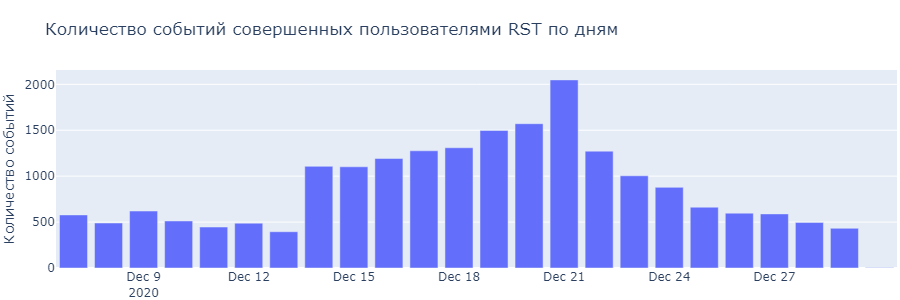

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
date,2020-12-07,2020-12-08,2020-12-09,2020-12-10,2020-12-11,2020-12-12,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30
user_id,578,490,620,512,446,488,395,1107,1102,1192,1276,1309,1497,1571,2048,1272,1004,878,662,597,589,495,432,4


In [34]:
df_event_rst = df_rst.groupby('date', as_index=False)['user_id'].count()

fig = go.Figure()

fig.add_trace(go.Bar(x=df_event_rst['date'], y=df_event_rst['user_id']))

fig.update_layout(
    autosize=False,
    width=900,
    height=300,
    title="Количество событий совершенных пользователями RST по дням",
    yaxis_title="Количество событий",
   
    barmode='overlay',
    margin=dict(l=10, r=0, t=70, b=0))

fig.show()

pd.set_option('max_columns', None)
display(df_event_rst.T)


Как видим трехкратный скачок с 13.12 на 14.12 (с 395 до 1107), а далее, с 16.12 спад с 1192 до 792, и далее плавное убывание вплоть до 29.12 до значения 49. 

`christmas&new year promo` проходила с 25.12.20 по 3.01.21. На гистограмме видим, что это не оказало сколько-нибудь существенного влияния. 

Продолжим по ТЗ и посмотрим на **активность пользователей участвующих в RST**

In [35]:
# список пользователей с нулями в событиях
nan_users = df_rst[df_rst['event_name'].isnull() == True]['user_id'].unique().tolist()
len(nan_users)

# они же с датами регистрации
dt_users_nan = users[users['user_id'].isin(nan_users)]

# Распределение пользователей с nan в событиях по группам А и В
users_part_nan = partpants[(partpants['user_id'].isin(nan_users)) & (partpants['ab_test']=='recommender_system_test')]
a_nan = users_part_nan[users_part_nan['group'] == 'A']['user_id'].unique().tolist()
b_nan = users_part_nan[users_part_nan['group'] == 'B']['user_id'].unique().tolist()

# Распределение их по группам
print('Неактивных пользователей в гурппе А:', len(a_nan))
print('Неактивных пользователей в гурппе B:', len(b_nan))


dt_a_nan = (
    users[users['user_id']
          .isin(a_nan)][['user_id', 'first_date']]
            .groupby('first_date', as_index=False)['user_id']
                .nunique()
                    .sort_values(by='first_date')
)
dt_b_nan = (
    users[users['user_id']
          .isin(b_nan)][['user_id', 'first_date']]
            .groupby('first_date', as_index=False)['user_id']
                .nunique()
                    .sort_values(by='first_date')
)

Неактивных пользователей в гурппе А: 916
Неактивных пользователей в гурппе B: 1602


Еще один повод уточнить у организаторов теста и тех кто его проводил, о каком изменении идет речь, и в чем суть второго теста. Ведь возможно не активность и такое большое количество nan-пользователей вызвано влиянием изменений предложенных в нем.

Рассмотрим количество регистрирующихся nan-пользователей по дням в группах А и В.

,first_date,user_id_x,user_id_y,diff
0,2020-12-07,175,70,2.500000
1,2020-12-08,83,88,0.943182
2,2020-12-09,53,22,2.409091
3,2020-12-10,110,132,0.833333
4,2020-12-11,60,79,0.759494
5,2020-12-12,187,127,1.472441
6,2020-12-13,248,186,1.333333


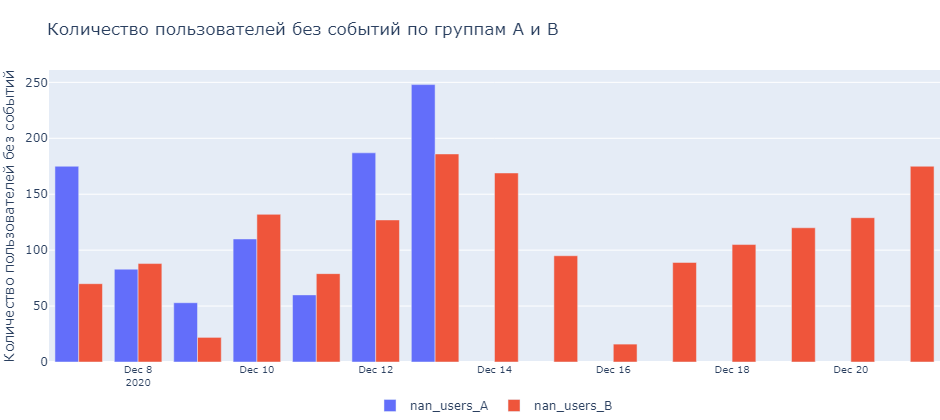

Количество неактивных пользователей пришедших в группы А и В с 7.12 по 13.12 включительно: 916 и 704


In [36]:
# Таблица с количеством зарегестрированных пользователей с 7.12 по 21.12 в группы А и B,
# где столбец diff - их отношение в А к В
dt_ab_nan = dt_a_nan.merge(dt_b_nan, on='first_date', how='inner')
dt_ab_nan['diff'] = dt_ab_nan['user_id_x']/dt_ab_nan['user_id_y'] 

display(dt_ab_nan)

# Визуализируем количество NAN пользователей по дням и группам А и В
fig=go.Figure()

fig.add_trace(go.Bar(
        x=dt_a_nan['first_date'],
        y=dt_a_nan['user_id'],
        #mode='lines+markers',
        name='nan_users_A'))

fig.add_trace(go.Bar(
        x=dt_b_nan['first_date'],
        y=dt_b_nan['user_id'],
        #mode='lines+markers',
        name='nan_users_B'))

fig.update_layout(
                  #barmode='stack',
                  autosize=False,
                  width=940,
                  height=420,
                  title="Количество пользователей без событий по группам А и В",
                  yaxis_title='Количество пользователей без событий',
                  legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=70, b=0))

fig.update_xaxes(tickfont=dict(size=10))

fig.show()

# Неактивных пользователей пришедших в В с 7.12 по 13.12 включительно
b_sum = dt_b_nan[dt_b_nan['first_date'] <= '2020-12-13']['user_id'].sum()

print(
    'Количество неактивных пользователей пришедших в группы А и В с 7.12 по 13.12 включительно:',
      dt_a_nan.user_id.sum(), 'и', b_sum
)

* Заметим, что с 7.12 по 13.12 такие пользователи попадали в обе группы теста, правда в разных количествах и в разном отношении ( от 4/5 до 5/2)
* 4 днях из 7 их было больше в А и в трех больше в В. Причем отношение А к В всегда превосходило отношение В к А. 
* Начиная с 14.12 такие пользователи стали попадать только в В, только в тестовую группу. 
* 14.12 в В пришло 169 пользователей, далее этот показатель к 16.12 упал до 16, 17.12 снова вырос до 89 и к 21.12 уже был на отметке 175 пользователей.

Как итог: неравномерность их распределения между тестовыми группами по дням и разное отношение по дням с 7.12 по 13.12 может говорить о случайности возникновения таких пользователей, а отсутствие "поступления" их в А с 14.12 ***как будто бы*** c негативными изменениями, вызванными новой рекомендательной системой. Но это еще предстоит проверить.

Заметим также, что на расчет конверсии по метрикам из ТЗ nan-пользователи влиять не будут, так как они "отвалились" уже на этапе перехода из регистрации в логин.

Пока мы можем посмотреть лишь на дополнительную информацию по этим пользователям. Например, с какого устройства была регистрация.

,index,device
0,Android,1128
1,PC,631
2,iPhone,532
3,Mac,227


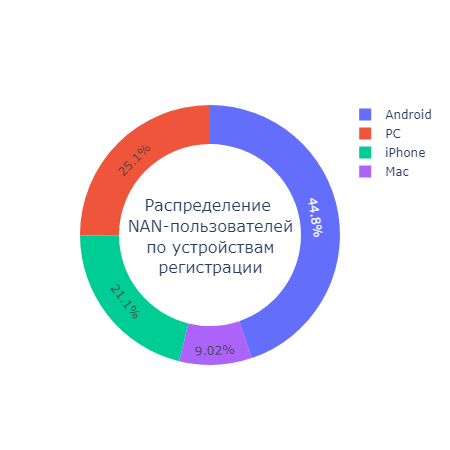

In [37]:
nan_add_inf = users[users['user_id'].isin(nan_users)]['device'].value_counts().reset_index()
display(nan_add_inf) 

fig = go.Figure()
fig.add_trace(go.Pie(values=nan_add_inf['device'], labels=nan_add_inf['index'], hole=0.7))

fig.update_layout(
    autosize=False,
    width = 450,
    height = 450,
    annotations=[dict(text='Распределение <br> NAN-пользователей <br> по устройствам <br> регистрации <br>',
                      x=0.5, y=0.5, font_size=16, showarrow=False)])

fig.show()

Немногим менее половины таких пользователей регистрировались с `Android`, с `PC` и `iPhone` четверть и пятая часть соответственно и всего немногим менее 1/10 с `Mac`. Примерно совпадает с общим распределением пользователей по устройствам.

Также в данных есть информация о некотором втором тесте, о котором нам ничего не известно, некий `interface_eu_test`, из названия - тест некоторого "интерфейса ЕС". Посмотрим внимательнее.

In [38]:
# Тест interface_eu_test или IET
interface = partpants[partpants['ab_test'] == 'interface_eu_test']

# NAN-пользоватлеи в таблице IET
nan_users_iet = interface[interface['user_id'].isin(nan_users)]

print('Количество nan-пользователей в IET:', nan_users_iet.shape[0])
print()

ab = ['A', 'B']
for g in ab:
    globals()[g+'group_iet'] = nan_users_iet[nan_users_iet['group'] == g]['user_id'].nunique()
    print('Количество nan-пользователей группы', g, ':', globals()[g+'group_iet'])
print() 

# nan-пользователи по группам iet
iet = partpants[partpants['ab_test'] == 'interface_eu_test']
print('IET группа А:', iet[iet['group'] == 'A']['user_id'].nunique())
print('IET группа В:', iet[iet['group'] == 'B']['user_id'].nunique())
print()

print('Nan-пользователи из IET по устройствам регистрации:\n',users[users['user_id'].isin(nan_users_iet.user_id.to_list())].reset_index()['device'].value_counts())

Количество nan-пользователей в IET: 363

Количество nan-пользователей группы A : 363
Количество nan-пользователей группы B : 0

IET группа А: 5831
IET группа В: 5736

Nan-пользователи из IET по устройствам регистрации:
 Android    166
PC          93
iPhone      65
Mac         39
Name: device, dtype: int64


* 363 пользователя, причем все в контрольной группе. Как будто бы удалось победить отсутствие активности у пользователей. 
* У `Android` снова почти половина. Снова `PC` и `iPhone` на втором и третьем, `Mac` на последнем.

По идее одна из групп контрольная (без изменения "интерфейса"), а вторая тестовая (возможно конечно, что обеим группам предлагались какие-то изменения). Если тестовая группа В, то логично предположить, что предложенные изменения могли повлиять на поведение пользователей, и тогда, будет целесообразно таких пользователей исключить. 

Но сначала посмотрим еще на конверсию из регистрации в логин по пользователям не вошедшим ни в `RST` ни в `IET`, пользователей `IET` и пользователям из группы А `RST`.

In [39]:
# Пользователи не участвующие ни в одном тесте
non_test_users_list = list(set(events['user_id'].unique().tolist())-set(partpants['user_id'].unique().tolist()))
len(non_test_users_list)

# Они же зарег с 7.12 по 21.12
non_test_users_list_dt = (
    users[
        (users['user_id'].isin(non_test_users_list)) 
          & (
              (users['first_date'] >= '2020-12-07') & (users['first_date'] <= '2020-12-21')
          )
    ]
    .user_id
    .unique()
    .tolist()
)

# Количество зарег и залогин не участвовавших ни в RST ни в IET
count_notest_reg = len(non_test_users_list_dt )
count_notest_log =  events[events['user_id'].isin(non_test_users_list_dt ) 
                        & (events['event_name']=='login')]['user_id'].nunique()

# Список пользователей IET зарегистрировавшихся с 7.12 по 21.12
iet_users_list = iet['user_id'].unique().tolist()
iet_users_list_dt = (
    users[
        (users['user_id'].isin(iet_users_list)) 
        & (
            (users['first_date'] >= '2020-12-07') & (users['first_date'] <= '2020-12-21')
          )
    ]
    .user_id
    .unique()
    .tolist()
)

# Количество зарег и залогин в IET
count_iet_reg = len(iet_users_list_dt)
count_iet_log =  events[events['user_id'].isin(iet_users_list_dt) 
                        & (events['event_name']=='login')]['user_id'].nunique()

# Отбираем пользователей RST группы А и кладем в список
a_users_rst = part_rst[(part_rst['user_id'].isin(users_list)) & (part_rst['group'] == 'A')]
a_users_rst_list = a_users_rst['user_id'].unique().tolist()

# Варианты списка пользователей группы А RST 
#a_users_rst_list = list(set(a_users_rst_list) - set(nan_users_iet['user_id'].unique().tolist()))
#a_users_rst_list = list(set(a_users_rst_list) - set(nan_users))
#a_users_rst_list = list(set(a_users_rst_list) - set(iet[iet['group'] == 'B']['user_id'].unique().tolist()))

# Количество зарег и залогин в RST
count_rst_reg = len(a_users_rst_list)
count_rst_log = events[(events['user_id'].isin(a_users_rst_list)) 
                       & (events['event_name'] == 'login')]['user_id'].nunique()

print('Количество  зарег. пользователей, которые не участвовали ни в IET ни в RST:', count_notest_reg)
print('Количество залогин. пользователей, которые не участвовали ни в IET ни в RST:', count_notest_log)

print()

print('Количество зарег. пользователей из IET:', count_iet_reg)
print('Количество залогин. пользователей из IET:', count_iet_log)

print()

print('Количество зарег. пользователей из группы А RST:', count_rst_reg)
print('Количество залогин. пользователей из группы А RST:', count_rst_log)

Количество  зарег. пользователей, которые не участвовали ни в IET ни в RST: 40804
Количество залогин. пользователей, которые не участвовали ни в IET ни в RST: 40799

Количество зарег. пользователей из IET: 10565
Количество залогин. пользователей из IET: 9847

Количество зарег. пользователей из группы А RST: 3195
Количество залогин. пользователей из группы А RST: 2279


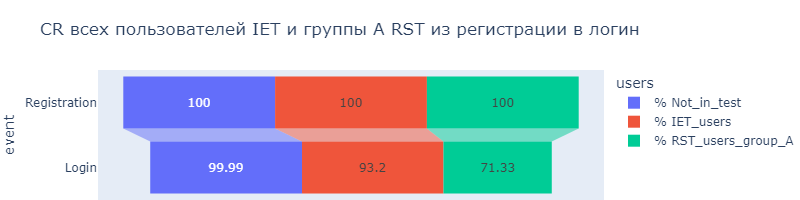

In [40]:
event = ['Registration', 'Login']

df_not = pd.DataFrame(
    dict(
        number=[count_notest_reg/count_notest_reg*100,
                round(count_notest_log/count_notest_reg*100, 2)], event=event)
)
df_not['users'] = '% Not_in_test'

df_iet = pd.DataFrame(
    dict(number=[count_iet_reg/count_iet_reg*100,
                 round(count_iet_log/count_iet_reg*100, 2)], event=event)
)
df_iet['users'] = '% IET_users'

df_rst_a = pd.DataFrame(
    dict(number=[count_rst_reg/count_rst_reg*100,
                 round(count_rst_log/count_rst_reg*100, 2)], event=event)
)
df_rst_a['users'] = '% RST_users_group_A'

df = pd.concat([df_not, df_iet, df_rst_a], axis=0)

fig = px.funnel(df, x='number', y='event', color='users')

fig.update_layout(
                  autosize=False,
                  width=800,
                  height=200,
                  title="CR всех пользователей IET и группы А RST из регистрации в логин",
                  
                  margin=dict(l=0, r=0, t=70, b=0))



fig.show()

Разница почти на 28% и 22% соответственно. Кажется, что влияние все же есть. Можно предположить, что оно проявится и для других метрик. И не похоже, что это обычный показатель конверсии для пользователей зарегистрированных с 7.12 по 21.12

Заметим, что nan-пользователи повлияли в одинаковой мере на всех пользователей IET как вместе взятых, так и отдельно по группам А и В. А также, что при удалении из группы А RST nan-пользователей конверсия из регистрации в логин сравнивается с аналогичным показателем пользователей не принимавших участия ни в IER ни в RST.

Видится целесообразным удалить неактивных пользователей из RST

In [41]:
dropna_rst_users = list(set(users_list) - set(nan_users))

In [42]:
# ЭТА ЯЧЕЙКА УБИРАЕТ НЕАКТИВНЫХ ИЗ RST!
df_rst = df_rst[df_rst['user_id'].isin(dropna_rst_users)]

print('Количество пользователей в RST после фильтрации от nan-пользователей:', df_rst['user_id'].nunique())

Количество пользователей в RST после фильтрации от nan-пользователей: 3050


И наконец последний пункт ТЗ - **горизонт событий в 14 дней**: 
* Отфильтруем `df_rst` по событиям, т.е. уберем события пользователей после 14 дней с момента регистрации
* Отфильтруем `df_rst` по пользователям, оставим только тех, кто "прожил" 14 дней

In [43]:
# Столбец с датой события date преобразуем в datetime64[ns] 
df_rst['date'] = pd.to_datetime(df_rst['date'], format='%Y-%m-%d')

# Возьмем максимальную дату события
df_rst['t_last_dt'] = df_rst['date'].max()
# Гипотетический лайфтайм
df_rst['lifetime'] = df_rst['t_last_dt'] - df_rst['first_date']
# Последняя дата по горизонту событий
df_rst['last_event_dt'] = df_rst['first_date'] + pd.Timedelta(14, 'D')
# Маркер попадания события до горизонта событий
df_rst['event_marker'] =( df_rst['date'] <= df_rst['last_event_dt'])*1
# Фильтруем df_rst по событиям и пользователям
df_rst = df_rst.query('(event_dt.isnull() or event_marker == 1) and lifetime >= "14 days"', engine='python')

display(df_rst.head())
print('Количество уникальных пользователей RST:', df_rst['user_id'].nunique())

,user_id,group,event_dt,event_name,price,date,first_date,device,t_last_dt,lifetime,last_event_dt,event_marker
0,d1aba3e2887b6a73,A,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020-12-07,PC,2020-12-30,23 days,2020-12-21,1
2,d1aba3e2887b6a73,A,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,2020-12-07,PC,2020-12-30,23 days,2020-12-21,1
4,d1aba3e2887b6a73,A,2020-12-07 14:43:27,product_page,NaN,2020-12-07,2020-12-07,PC,2020-12-30,23 days,2020-12-21,1
6,d1aba3e2887b6a73,A,2020-12-07 14:43:27,login,NaN,2020-12-07,2020-12-07,PC,2020-12-30,23 days,2020-12-21,1
14,dabc14fddfadd29e,A,2020-12-08 11:30:58,login,NaN,2020-12-08,2020-12-08,Mac,2020-12-30,22 days,2020-12-22,1


Количество уникальных пользователей RST: 1675


In [44]:
print('Пользователей в группе А:', df_rst[df_rst['group'] == 'A']['user_id'].nunique())
print('Пользователей в группе B:', df_rst[df_rst['group'] == 'B']['user_id'].nunique())

Пользователей в группе А: 1145
Пользователей в группе B: 530


Всего 1675 пользователей, около 1/3 от заявленных в ТЗ. Но таковы требования ТЗ, которые по исходным данным несколько взаимоисключают друг друга. Фильтрация по горизонту событий видится приоритетнее, нежели точное число участников теста. Хотя уменьшение последнего, также может усложнить проведение теста, а именно возможности объективно зафиксировать изменения.

**ВЫВОДЫ**<br>
Проверили данные на соответствие ТЗ и доп. требования по пересечению пользователей между тестами и группами:
* Выяснили, что проводилось два теста `interface_eu_test` и `recommender_system_test`. О втором тесте ничего не известно.
* До фильтрации пользователей RST в контрольной группе - 3824 пользователя, в тестовой - 2877.
* Количество пользователей попавших в оба теста - 1602.
* Часть пользователей исследуемого теста, участвовали в IET, а именно 921 пользователь в группе А и 681 пользователь в группе В.
* Аналогичное распределение, но теперь только пользователей группы В IET распределились так: 439 в А и 344 в В.
* Предполагая, что группа В второго теста являлась тестовой и на ее пользователей оказывали влияния какие-то изменения (возможно новый интерфейс) приняли решение исключить таких пользователей из исследуемого теста. Количество пользователей сократилось до 5918.
* Проверили, есть ли пользователи RST попавшие как в тестовую, так и в контрольную группы. Таких пользователей нет.
* Отфильтровали пользователей по срокам проведения теста, региону. Осталось 5568.
* Проверили влияние маркетинговых акций на пользователей теста (в указанное время проходила только одна, и никакого всплеска активности не вызвала).
* Наибольшая активность пользователей RST пришлась на 14.12 - 21.12.
* Обнаружили неактивных пользователей RST - прошли регистрацию и не совершили ни одного события. В группе А их 916, в В 1602.
* Во втором тесте их всего 363 только в группе А. Заметили неравномерность их регистрации по дням, и что после 13.12 они "приходили" только в группу В. 
* Рассмотрели конверсию из регистрации в логин трех подмножеств исходного множества пользователей: 1. Пользователи не вошедшие ни в один из двух тестов; 2. Пользователи IET; 3. Пользователи контрольной группы RST. Из 100 зарегистрировавшихся пользователей, не попавших ни в один из тестов, почти все (из 40 тыс. потерялись всего 5 человек) логинятся, среди пользователей IET таких уже около 93 человек, а вот среди пользователей контрольной группы RST уже всего около 71. 
* Убрали из RST неактивных пользователей, осталось 3050. Уде почти половина от заявленных в ТЗ.
* Отфильтровали пользователей не проживших 14 дней и события после горизонта событий. Ушла еще половина от предыдущего шага, осталось 1615.

## Исследовательский анализ данных

Исследуем распределение событий на пользователя, на дату, построим воронки событий и проанализируем конверсию.

### Распределение количества событий на пользователя в группах А и В 

Посмотрим как распределено количество событий на пользователя в группах А и В RST.

Количество полльзователей без событий в группе А: 0
Количество полльзователей без событий в группе B: 0


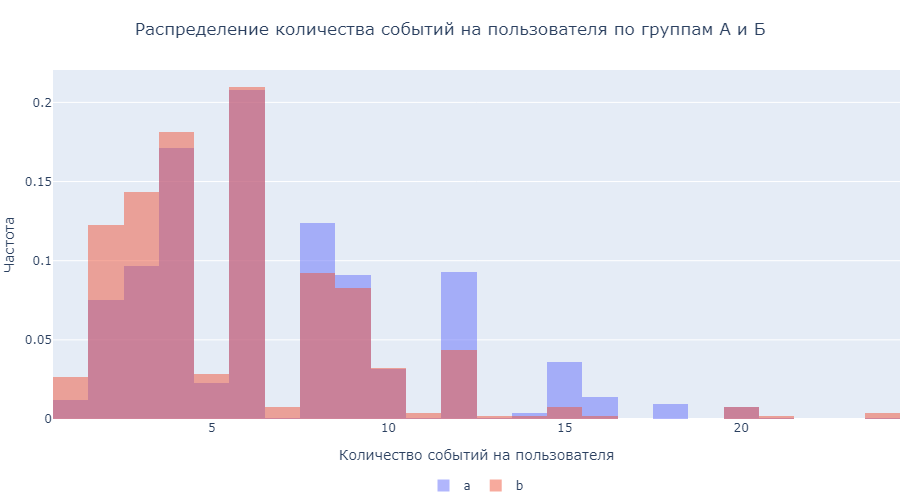

In [45]:
# Группируем по пользователям и считаем сумму в event_marker
a_event_users = df_rst[df_rst['group']=='A'].groupby('user_id',as_index=False)['event_marker'].sum()
b_event_users = df_rst[df_rst['group']=='B'].groupby('user_id',as_index=False)['event_marker'].sum()

print('Количество полльзователей без событий в группе А:',
      a_event_users.query('event_marker == 0').shape[0])

print('Количество полльзователей без событий в группе B:',
      b_event_users.query('event_marker == 0').shape[0])

# Чтобы получить распределение не содержащее nan-пользователей
#a_event_users = a_event_users.query('event_marker != 0')
#b_event_users = b_event_users.query('event_marker != 0')

g_list=['a', 'b']
fig = go.Figure()
for g in g_list:
    fig.add_trace(
        go.Histogram(
            x=globals()[g+'_event_users']['event_marker'],
            histnorm='probability density',
            opacity=0.5,
            name=g,
            nbinsx=40)
    )

fig.update_layout(
    autosize=False,
    width=900,
    height=500,
    title="Распределение количества событий на пользователя по группам А и Б",
    title_x = 0.5,
    xaxis_title="Количество событий на пользователя",
    yaxis_title="Частота",
    legend=dict(x=.5, xanchor="center", orientation="h", y=-.15),
    barmode='overlay',
    margin=dict(l=0, r=0, t=70, b=0))

fig.show()

В целом можем заметить, что распределение количества событий на пользователя в контрольной и тестовой группах похожи, с некоторым преобладанием по количеству событий на пользователя то в контрольной, то в тестовой группах (для малого количества от 1 до 7 больше в тестовой, для 8,9,12, 14-18 больше в контрольной). Заметим, что если оставить nan-пользователей, то ситуация измениться почти на противоположную.

In [46]:
st_df = pd.concat([a_event_users.describe(), b_event_users.describe()], axis=1)
st_df.columns = ['A', 'B']

display(st_df)

print(np.percentile(a_event_users['event_marker'], [90, 95, 99]))
print(np.percentile(b_event_users['event_marker'], [90, 95, 99]))

,A,B
count,1145.000000,530.000000
mean,6.939738,5.722642
std,3.918849,3.470706
min,1.000000,1.000000
25%,4.000000,3.000000
50%,6.000000,5.000000
75%,9.000000,8.000000
max,24.000000,24.000000


[12. 15. 18.]
[10. 12. 20.]


* Средние значения количества событий на пользователя в выборках отличаются всего примерно на 1 (в пользу контрольной группы)
* 25 процентиль, медианные значения и 75 процентили аналогично предыдущему пункту.
* Минимальные и максимальные значения одинаковые.
* До 95 процентиля контрольная группа превосходит тестовую, далее наоборот. 

### Распределение количества событий в группах А и В по дням

Посмотрим как собятия, совершенные пользователями, распределились по дням в кадой из групп А и В

In [47]:
dt_event_ab = (
    df_rst[df_rst['group'] == "A"]
    .groupby('date', as_index=False)['event_marker']
    .sum()
    .merge(
        df_rst[df_rst['group'] == "B"]
        .groupby('date', as_index=False)['event_marker']
        .sum()
        , on='date',
        how='outer')
    .rename(columns={'event_marker_x': 'event_count_a', 'event_marker_y': 'event_count_b'})
)

dt_event_ab

,date,event_count_a,event_count_b
0,2020-12-07,263,315
1,2020-12-08,283,207
2,2020-12-09,331,289
3,2020-12-10,294,218
4,2020-12-11,309,137
5,2020-12-12,319,169
6,2020-12-13,273,122
7,2020-12-14,880,227
8,2020-12-15,915,187
9,2020-12-16,870,322


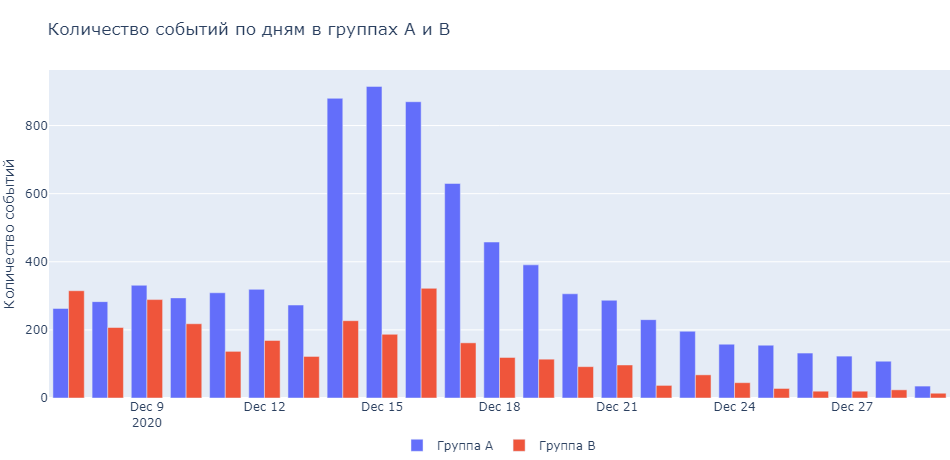

In [48]:

fig = go.Figure()

fig.add_trace(
        go.Bar(
            x = dt_event_ab['date'],
            y = dt_event_ab['event_count_a'],
            name = 'Группа А')
            )
fig.add_trace(
        go.Bar(
            x = dt_event_ab['date'],
            y = dt_event_ab['event_count_b'],
            name = 'Группа В')
            )


fig.update_layout(
    #barmode='stack',
    autosize=False,
    width=950,
    height=460,
    title="Количество событий по дням в группах А и В",
    yaxis_title='Количество событий',
    legend_orientation="h",
    legend=dict(x=.5, xanchor="center"),
    margin=dict(l=0, r=0, t=70, b=0),
    yaxis={'categoryorder':'total ascending'}
)
                         
fig.show()



* Заметим, что в целом по дням количество событий в группе А всегда больше чем в группе В. Исключение только 7.12, старт теста.
* При этом события в группе В распределены более равномерно и до 16.12 убывают с 356 и снова  возрастают до 369 и далее плавно убывают до 14 к 29.12.
* События в группе А напротив, более менее равномерно распределены с 7.12 по 13.12 (308-371), далее резкий более чем трехкратный скачок до 1015 14.12 и с 16.12 резко убывает до 42 к 29.12.

In [49]:
ud = df_rst[(df_rst['date'] >= '2020-12-14') & (df_rst['date'] <= '2020-12-16')]['user_id'].unique().tolist()

partpants[(partpants['user_id'].isin(ud)) & (partpants['ab_test'] == 'interface_eu_test')]['group'].value_counts()

A    157
Name: group, dtype: int64

### Конверсии на разных этапах в группах А и В

Посмотрим на воронку событий пользоватей RST по группам А и В

In [50]:
a_us = (
    df_rst[df_rst['group']=='A'].event_name
    .value_counts()
        .reset_index()
            .rename(columns={'index':'event_name', 'event_name':'count'})
)
a_us['group'] = 'A'

b_us = (
    df_rst[df_rst['group']=='B'].event_name
    .value_counts()
        .reset_index()
            .rename(columns={'index':'event_name', 'event_name':'count'})
)
b_us['group'] = 'B'


display(a_us)

display(b_us)


,event_name,count,group
0,login,3578,A
1,product_page,2237,A
2,product_cart,1095,A
3,purchase,1036,A


,event_name,count,group
0,login,1462,B
1,product_page,791,B
2,product_cart,402,B
3,purchase,378,B


Создадим таблицу `funnels` с количеством уникальных пользователей совершивших перечисленные события.

In [51]:
funnels = df_rst.pivot_table(index='event_name', 
                             values='user_id', 
                             columns='group', 
                             aggfunc='nunique').reset_index().sort_values(by='A', ascending=False)

funnels

group,event_name,A,B
0,login,1145,529
2,product_page,723,296
1,product_cart,350,149
3,purchase,342,148


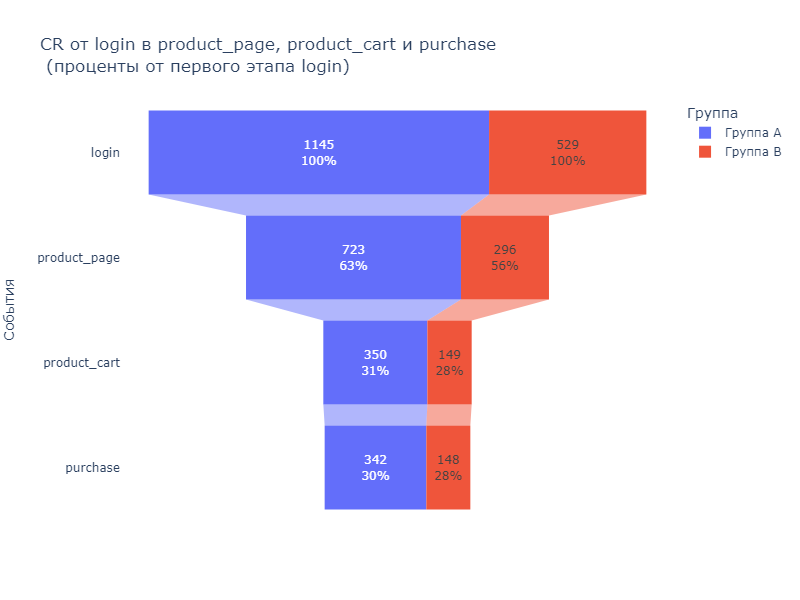

In [52]:
fig = go.Figure()

fig.add_trace(
    go.Funnel(
        name = 'Группа А',
        y = funnels.event_name,
        x = funnels['A'],
        textinfo = "value+percent initial"    
    )

)

fig.add_trace(
    go.Funnel(
        name = 'Группа B',
        orientation = 'h',
        y = funnels.event_name,
        x = funnels['B'],
        
        textposition = 'inside',
        textinfo = "value+percent initial"    
    )

)

fig.update_layout(
    title="CR от login в product_page, product_cart и purchase<br> (проценты от первого этапа login)",
    legend = {'title':'Группа'},
    width = 800,
    height = 600,
    yaxis_title='События',
    template = 'plotly_white'
)

fig.show()

Тестовая группа на каждом этапе отстает от контрольной 2% до 7%. Заметим, что только около 30 и 28 человек из 100 контрольной и тестовой групп соответственно добираются до кнопки "КУПИТЬ".

Посмотрим на воронку конверсии от предыдущего шага.

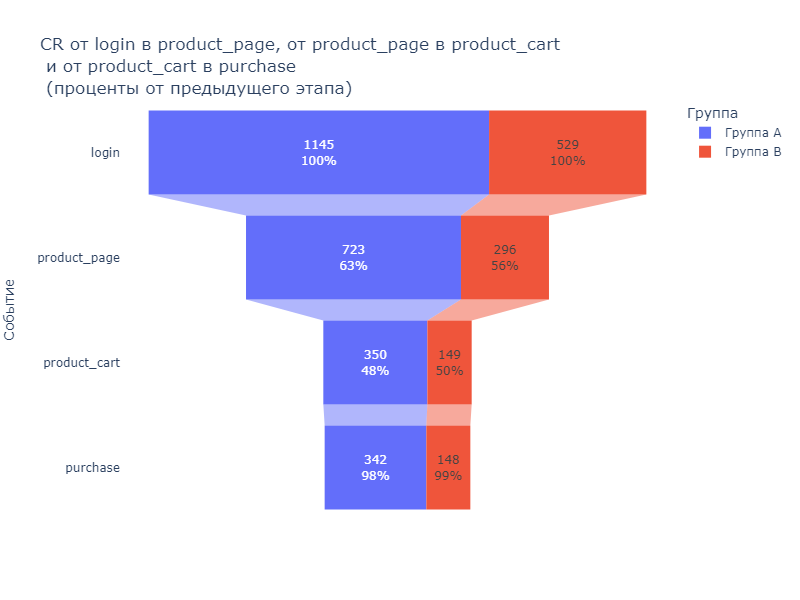

In [53]:
fig = go.Figure()

fig.add_trace(
    go.Funnel(
        name = 'Группа А',
        y = funnels.event_name,
        x = funnels['A'],
        textinfo = "value+percent previous"    
    )

)

fig.add_trace(
    go.Funnel(
        name = 'Группа B',
        orientation = 'h',
        y = funnels.event_name,
        x = funnels['B'],
        
        textposition = 'inside',
        textinfo = "value+percent previous"    
    )

)

fig.update_layout(
    title="CR от login в product_page, от product_page в product_cart<br> и от product_cart в purchase<br> (проценты от предыдущего этапа)",
    legend = {'title':'Группа'},
    width = 800,
    yaxis_title = 'Событие',
    height = 600,
    template = 'plotly_white'
)

fig.show()

Заметим, что конверсия в страницу товара, у тестовой группы ниже на 7%, зато конверсия со страницы товара в корзину на 2% выше в отличие от контрольной группы. При этом к покупке пользователи тестовой группы и контрольной приходят с корзины почти в равных долях (разница всего процент в пользу контрольной группы.)

По идее, новая рекомендательная система должна предлагать пользователю товар, который в большинстве случаев его заинтересует, так как предлагаемый продукт подобран с учетом его предпочтений. И если группе В предлагали улучшенную, реально работающую рекомендательную систему, то конверсию в `product_page` можно ожидать выше, чем в контрольной группе, ведь этот этап и есть просмотр товара, выбранный из числа интересных для пользователя. 

На этой воронке видим, что действительно конверсия из страницы в корзину увеличились, но из логина на страницу упала.

Заметим, что nan-пользователи не влияют на конверсию в `product_page`, `product_cart` и `purchase` так как они "отвалились" еще на этапе registration to login.

### Особенности данных

Прежде чем проводить тест примем во внимание особенности данных, которые мы обнаружили на предыдущих этапах:

1. Несоответствие данных отдельным пунктам ТЗ, а именно:
* *Дата остановки: 2021-01-04.* В имеющихся данных последний день активности пользователей 2020-12-29
* *Ожидаемое количество участников теста: 6000.* После очистки данных в соответствии с пунктами ТЗ при условии фильтрации неактивных пользователей 1675 участников теста.
2. Упомянутые в п.1 nan-пользователи. Конверсия из регистрации в логин пользователей, не вошедших ни в один из тестов, равна почти 100%, в то время как контрольная группа RST имеет показатель всего в 72%. Также заметили, что динамика привлечения таких пользователей в группы А и В RST не имеет каких-то детектируемых закономерностей, как например одинаковое отношение таких пользователей в контрольной и тестовой группах по дням. И начиная с  14.12 такие пользователи стали "приходить" только в группу B.
3. Был замечен всплеск активности пользователей контрольной группы с 14.12 по 16.12 включительно. При том что никаких маркетинговых событий, акций на эти даты не значится. И в целом в день, в контрольной группе событий больше (в указанный промежуток времени до 3х раз).
4. Nan-пользователи оказали влияние на распределение количества событий на пользователя в обеих группах. Отметим, что их количество распределилось не совсем равномерно, в тестовой группе их больше чем в контрольной. И на визуализации распределения количества события на пользователя мы заметили превосходство по отдельным показателям группы А, а на очищенных от nan-пользователей данных, группы В над А.
5. Среди пользователей RST были пользователи участвующие в этот момент еще и в IET. Про второй тест ничего не известно, из названия можно лишь предположить, что тестовой группе этого теста предлагали новый интерфейс, причем `eu` может говорить о том, что пользователи были из Европы.
6. Проведенная очистка данных RST привела малочисленным контрольной и тестовой группам, что может затруднить корректность исследования результатов стат тестов.


**ВЫВОДЫ**<br>
* Распределение количества событий на пользователя почти одинаковые, за небольшим преимуществом тестовой группы для небольших значений и контрольной для значений выше среднего.
* По количеству событий в день в контрольная группа превосходит тестовую в каждый день с 7.12 по 21.12, в отдельные дни до 6 раз. Заметили пик событий в контрольной группе с 14.12 по 16.12.
* Конверсия от этапа `login` к этапам `product_page`, `product_cart`, `purchase` в тестово группе стабильно ниже чем в контрольной (разница на 2 - 7 процентов).
* Конверсия от предыдущего шага у тестовой группы ниже с логина на страницу товара на 7%, и выше на 2% и на 1% со страницы товара в корзину и с корзины в покупку соответственно.
* Особенности, которые нужно учесть прежде чем приступать к А/В тесту мы указали в предыдущем блоке. 

## Оценка результатов А/В тестирования

Перейдем к оценке результатов проведенного теста. Еще раз отметим, что в ходе обработки данных не все пункты ТЗ удалось выполнить, так как они в ощутимой мере противоречили друг другу. 

### Относительные изменения конверсии группы В к А.

Рассмотрим относительное изменение конверсии тестовой группы к контрольной. 

In [54]:
# Конерсия с предыдущего шага
con_a =[]
con_b =[]
for i in range(0,3):
    x = round(funnels.iloc[i+1,1]/funnels.iloc[i,1]*100, 2)
    y = round(funnels.iloc[i+1,2]/funnels.iloc[i,2]*100, 2)
    con_a.append(x)
    con_b.append(y)
    
con_a = [100] + con_a
con_b = [100] + con_b
# Списки конверсий по группам в таблицы
con_a = pd.DataFrame({'event_name': ['login', 'product_page', 'product_cart', 'purchase'] , 'cr_a': con_a})
con_b = pd.DataFrame({'event_name': ['login', 'product_page', 'product_cart', 'purchase'] ,'cr_b': con_b})

# Присоединим их к funnels
funnels = funnels.merge(con_a, on='event_name')
funnels = funnels.merge(con_b, on='event_name')
# Добаляем столбец с относительными значениями (В/А-1)
funnels['relat_cr'] = round(funnels['cr_b']/funnels['cr_a'] - 1, 2)

funnels

,event_name,A,B,cr_a,cr_b,relat_cr
0,login,1145,529,100.00,100.00,0.00
1,product_page,723,296,63.14,55.95,-0.11
2,product_cart,350,149,48.41,50.34,0.04
3,purchase,342,148,97.71,99.33,0.02


Ни на одном шаге не видим +10% в В относительно А. Максимум 4% в конверсии от `product_page` к `product_cart` . А от логина к странице товара так и вовсе -11%. Видимо рекомендательная система здесь все-таки не сработала как заявлено в ТЗ.

### Проверка статистической разницы долей групп А и В

Подготовим данные для стат теста

In [55]:
# Количество пользователей по группам
users_group = (
    pd.DataFrame({'group': ['A', 'B'],
                  'users_count': 
                  [df_rst[df_rst['group'] == 'A']['user_id'].nunique(),
                   df_rst[df_rst['group'] == 'B']['user_id'].nunique()]})
)
users_group = users_group.set_index('group')

# Немного преобразуем таблицу funnels
funnels = funnels.set_index('event_name')
funnels = funnels.iloc[1:].reset_index().set_index('event_name')

display(users_group, funnels)

,users_count
group,
A,1145
B,530


,A,B,cr_a,cr_b,relat_cr
event_name,,,,,
product_page,723,296,63.14,55.95,-0.11
product_cart,350,149,48.41,50.34,0.04
purchase,342,148,97.71,99.33,0.02


Готово. 

Так как мы хотим определить находят ли статистические критерии разницу между тестовой и контрольной группами, в которых нас интересуют конверсии (с логина на страницу товара,со страницы товара на корзину, с корзины на покупку) т.е. доли, то используем z-тест (z-критерий Фишера)

Сформулируем гипотезы для проверки наличия стат значимого различия по долям в контрольной и тестовой группах RST:<br>

**H0** - конверсии контрольной и тестовой групп по событию event равны<br>
**Н1** - конверсии контрольной и тестовой групп по событию event НЕ равны

In [56]:
# Создадим функцию для автоматизации процесса проведения стат теста
def z_test (event, alpha): 
    
    succs_a = funnels.loc[event, "A"]
    trial_a = users_group.loc['A', 'users_count'] 
    
    succs_b = funnels.loc[event, "B"] 
    trial_b = users_group.loc['B', 'users_count'] 
    
    # пропорция успехов по группам
    p_a = (succs_a / trial_a)
    p_b = (succs_b / trial_b) 
    print(succs_a, succs_b, trial_a, trial_b)
    
    diff = (p_a - p_b)
    
    # "комбинированная пропорция" успехов
    p_combo = (succs_a + succs_b ) / (trial_a + trial_b) 
    
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = diff / math.sqrt(p_combo * (1 - p_combo) * (1 / trial_a + 1 / trial_b))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Для групп A и B события: {}, p_value=: {p_value:.9f}'.format(event, p_value=p_value))
    
    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть статистически значимая разница')
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли статистически разными")

Учитывая что мы проводим множественный тест, а именно 3 теста да еще и по зависимым друг от друга событиям, то необходимо скорректировать значение альфа, чтобы оставаться в рамках 0.05 и контролировать ошибку первого рода!

In [57]:
# Поправка Бонферрони 
alfa = 0.05/3

# пройдемся циклом по событиям групп A и В и применим функцию z_test.
for event in funnels.index:
    z_test(event, alfa)
    print()

723 296 1145 530
Для групп A и B события: product_page, p_value=: 0.004445257
Отвергаем нулевую гипотезу: между долями есть статистически значимая разница

350 149 1145 530
Для групп A и B события: product_cart, p_value=: 0.307000979
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли статистически разными

342 148 1145 530
Для групп A и B события: purchase, p_value=: 0.415894987
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли статистически разными



Видим, что стат значимое различие есть только при конверсии из логина в страницу продукта. И как мы видели выше, это различие не в пользу тестовой группы. Конверсия по остальным событиям стат значимо не различается. А значит мы не можем сказать о том что  новая рекомендательная система улучшила указанные метрики.

## Общий вывод

В нашем распоряжении были данные об активности пользователей и результатах проведенного А/В тестирования `recommender_system_test`, предоставленные компанией `N`. Задача состоял в том, чтобы оценить корректность проведенного теста, соответствие его установленному ТЗ и проанализировать полученные результаты А/В теста RST. 

**Результаты оценки корректности проведения теста**
В одновременном проведении двух тестов ничего плохого нет, но когда пользователи этих двух тестов пересекаются, то определить что же действительно повлияло на изменение замеряемых метрик становится затруднительно, если и вовсе невозможно. В нашем случае пересечения между пользователями двух тестов были, и фильтрация сильно сократила размер тестируемой аудитории (с 6701 до 5918). 
Тем самым требование ТЗ относительно аудитории в 6000 пользователей уже не может быть выполнено. А после фильтрации данных по региону EU и срокам проведения, получили уже 5568 участников теста. 

Далее были обнаружены неактивные пользователи, которые после регистрации никаких событий не совершали. Было определено, что их количество набиралось в группы неравномерно, и даже с 14.12 они стали регистрироваться только в тестовую группу. Этот факт сильно повлиял на распределение количества событий на пользователя в контрольной и тестовой группах. Причина возникновения такого большого числа неактивных пользователей осталась неясна. 

Выполняя один из последних пунктов ТЗ аудитория теста в очередной раз сократилась, и после исключения из нее неактивных пользователей и пользователей не проживших 14 дней, в тесте осталось всего 1615 пользователей. Пользователи между группами распределились так: 1145 пользователей в контрольной группе А и 530 в тестовой группе В, т.е. почти 2 к 1.

**Вывод:** не все пункты ТЗ были соблюдены, в ходе фильтрации аудитория теста потеряла почти 2/3 участников. Т.е. мы получили значительное уменьшение выборки, а значит потеряли в мощности теста, и тем самым возросла вероятность получить ошибку второго рода, т.е. оказаться в ситуации когда мы не сможем зафиксировать настоящие изменения.

**Результаты проведенного А/В теста**
Анализ проведенного А/В теста показал, что завяленных улучшений, таких метрик как конверсии в просмотр карточек товаров — событие `product_page`, просмотры корзины — `product_cart`, покупки — `purchase` на 10% не произошло. В первой даже потеряли 11%, в двух остальных улучшения всего 4% и 2% соответственно.<br>
Проверка статистической разницы долей исследуемых выборок показала, что лишь для первой метрики (конверсии в просмотр карточек товаров) удалось отвергнуть нулевую гипотезу об отсутствие стат значимых различий между долями, а значит стат значимое различие есть. Для двух остальных (конверсия в просмотры корзины, конверсия в покупки)- отвергнуть нулевую гипотезу не удалось, а значит стат значимых различий между долями нет.

**Вывод:** учитывая результаты оценки корректности проведенного А/В теста и потерю мощности теста у нас нет возможности объективно прогнозировать результаты к которым может привести "раскатывание" новой рекомендательной системы на всю целевую аудиторию.

### Дополнительные материалы

[БАГ- РЕПОРТ](https://disk.yandex.ru/d/gXtR3PsVC0JPrQ)